###Устанавливаем необходимые библиотеки

In [ ]:
!pip install moviepy torchopenl3

### Импортируем (подключаем) необходимые библиотеки

In [ ]:
from moviepy.editor import VideoFileClip # разделение на на аудио и кадры
import moviepy.editor as mp
import soundfile as sf # чтение .wav файла и подготовка для эмбеддинга
import torchopenl3 # эмбеддинг аудио
import numpy as np
import cv2
import tensorflow as tf
from sklearn.preprocessing import StandardScaler # нормализация
from sklearn.decomposition import PCA # понижение размерности
import math
import matplotlib.pyplot as plt # отображения графа матрицы расстояний
from scipy.spatial.distance import cdist # вычисление матрицы расстояний
import networkx as nx # Page Rank

### Подключаем гугл диск. Разрешаем доступ

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


###В гугл диск должно быть загружено наше видео в архивированном формете zip

In [ ]:
PATH = '/content/drive/MyDrive/' # абсолютный пусть к нашему хранилищу
ZIPFILE = PATH+'film1.zip' # измените название архива на название Вашего архива
VIDEO_FILE = PATH+'film1.mp4' # аналогично измените название mp4 файла на название Вашего видео файла

In [ ]:
!unzip $ZIPFILE -d $PATH

Archive:  /content/drive/MyDrive/film1.zip
  inflating: /content/drive/MyDrive/film1.mp4  


### Разделение видео на аудио и видео(без звука) файлы

In [ ]:
video = VideoFileClip(VIDEO_FILE)

audio_file = PATH+"audio.wav"
video.audio.write_audiofile(audio_file, codec='pcm_s16le')

# video_without_audio_file = PATH+"video.mp4"
# video_without_audio = video.set_audio(None)
# video_without_audio.write_videofile(video_without_audio_file, codec="libx264")

video.close()

t:  29%|██▉       | 1838/6308 [05:13<10:14,  7.28it/s, now=None]

MoviePy - Writing audio in /content/drive/MyDrive/audio.wav



t:  29%|██▉       | 1838/6308 [05:17<10:14,  7.28it/s, now=None]

MoviePy - Done.


In [ ]:
# выгрузка аудио и видео (если уже выполнено разделение)
audio_file = PATH+"audio.wav"
video_file = PATH+"film1.mp4"

### Длина искомого отрезка в секундах

In [ ]:
SEGMENT_LEN = 10

# Количество самых важных отрезков, можно изменить под Ваши требования
COUNT_IMPORTNANT_SEGMENTS = 5

### Получение эмбеддинга аудио

In [ ]:
def process_audio_segments(audio_file, segment_length=SEGMENT_LEN):
    # Читаем аудиофайл для дальнейшего использование в функции, туториал из документации: https://colab.research.google.com/drive/1LHbM1WN_1LK61R6XEbUlrtmRb3fKlDov?usp=sharing
    audio, sr = sf.read(audio_file)
    audio_length = len(audio) / sr  # Длина аудиофайла в секундах

    # Разделяем аудиофайл на отрезки длиной в segment_length секунд
    segments = []
    for start_time in range(0, int(audio_length), segment_length):
        end_time = min(start_time + segment_length, audio_length)
        start_frame = start_time * sr
        end_frame = end_time * sr
        segment = audio[start_frame:end_frame]
        segments.append(segment)

    # Обрабатываем каждый отрезок аудио
    embeddings = []
    for segment in segments:
        emb_audio, _ = torchopenl3.get_audio_embedding(segment, sr, content_type="env",
                                                       input_repr="linear", embedding_size=512)
        # Преобразуем тензор в массив NumPy
        emb_audio_np = emb_audio.numpy()
        # Усредняем значения для всего отрезка
        mean_emb_audio = np.mean(emb_audio_np, axis=1)
        mean_emb_audio = mean_emb_audio.reshape(-1)
        embeddings.append(mean_emb_audio)

    return np.array(embeddings)

audio_embeddings = process_audio_segments(audio_file)
print(f"Размерность матрицы эмбеддингов: {audio_embeddings.shape}")

Размерность матрицы эмбеддингов: (21, 512)


In [ ]:
# сохранение аудио эмбединга, опционально
np.save(PATH+"audio_emb.npy", audio_embeddings)

### Получение признаков из видео

In [ ]:
#модель
base_model = tf.keras.applications.MobileNetV2(
    include_top=False, weights='imagenet', input_shape=(224, 224, 3))

def embed_frame(frame):
    frame_resized = cv2.resize(frame, (224, 224))
    frame_resized = np.expand_dims(frame_resized, axis=0)
    frame_resized = frame_resized / 255.0
    embedding = base_model.predict(frame_resized)
    return embedding

def process_video(video_file, segment_length=SEGMENT_LEN):
    cap = cv2.VideoCapture(video_file)
    features = None
    frame_count = 0

    while(cap.isOpened()):
        ret, frame = cap.read()
        if not ret:
            break

        frame_embedding = embed_frame(frame)

        if features is None:
            features = frame_embedding
        else:
            features += frame_embedding

        frame_count += 1

        # Проверяем, прошло ли 5 секунд и обрабатываем отрезок
        if frame_count % (segment_length * cap.get(cv2.CAP_PROP_FPS)) == 0:
            if features is not None:
                features /= frame_count
                yield features.flatten()
                features = None
                frame_count = 0

    cap.release()

video_embeddings = np.array(list(process_video(video_file)))
print(f"Размерность матрицы эмбеддингов: {video_embeddings.shape}")

Выходные данные были обрезаны до нескольких последних строк (5000).
1/1 [==============================] - 0s 58ms/step
Размерность матрицы эмбеддингов: (21, 62720)


In [ ]:
# сохранение видео эмбединга, опционально
np.save(PATH+"video_emb.npy", video_embeddings)

### Конкатенация векторов, нормализация и уменьшение размерности

In [ ]:
# загрузка эмбеддингов, опционально
audio_embeddings = np.load(PATH+"audio_emb.npy")
video_embeddings = np.load(PATH+"video_emb.npy")

In [ ]:
print(audio_embeddings.shape)
print(video_embeddings.shape)

(21, 512)
(21, 62720)


In [ ]:
#конкатенация аудио и видео в один вектор
concatenated_embeddings = np.concatenate((audio_embeddings, video_embeddings), axis=1)
print(concatenated_embeddings.shape)

(21, 63232)


In [ ]:
# Создаем экземпляр StandardScaler
scaler = StandardScaler()

# Применяем scaler к объединенному вектору
normalized_embeddings = scaler.fit_transform(concatenated_embeddings)

print(normalized_embeddings.shape)
print(normalized_embeddings)

(21, 63232)
[[ 1.523715    0.46056086 -1.7973458  ...  4.343138   -0.3413435
  -0.42212665]
 [ 0.79250795  0.97031486  0.06211486 ... -0.27321157 -0.6704043
   2.1765022 ]
 [ 2.3025715   1.3453232  -0.74431777 ... -0.27321157  0.34494516
  -0.04453054]
 ...
 [ 0.511163    0.00695014  0.22351919 ... -0.27321157 -0.45074955
   2.1510243 ]
 [-1.0120714   0.23289399 -0.6979709  ... -0.27321157 -0.6704043
  -0.7502906 ]
 [-0.84593207 -0.26761094 -0.12024552 ... -0.27321157 -0.6704043
  -0.81782335]]


In [ ]:
def get_video_duration(video_file):
    video = VideoFileClip(video_file)
    duration_seconds = video.duration
    duration_minutes = duration_seconds / 60
    return duration_minutes

# корень из количества минут видео - оптимальное количество отрезков для обработки
video_duration_minutes = get_video_duration(VIDEO_FILE)
components = math.sqrt(video_duration_minutes)
if(normalized_embeddings.shape[0] < 15):
  components = normalized_embeddings.shape[0]
elif(components < 15):
  components = 15

# Создаем объект PCA
pca = PCA(n_components=components)

# Преобразовываем вектор с помощью метода PCA
result_vector = pca.fit_transform(normalized_embeddings)

print("Reduced vector shape:", result_vector.shape)

Reduced vector shape: (21, 15)


In [ ]:
print(result_vector)

[[ 1.35937775e+02  1.78680956e+00  4.42980003e+01 -4.02972412e+01
   2.64597912e+01 -2.70497742e+01 -1.32921636e-01 -4.06950874e+01
  -1.10169044e+02 -1.01374102e+01 -1.45972080e+01  6.65826035e+01
  -5.55408859e+01  1.30989807e+02 -2.19004841e+01]
 [ 1.13086456e+02  4.13118095e+01  8.47688065e+01  5.37570953e+00
  -3.64304047e+01 -6.48557281e+01  4.22169924e-01  5.17270203e+01
  -6.81153336e+01 -8.05531216e+00  9.98246002e+01  8.08294296e+01
   4.97684956e+00 -1.07937851e+02  2.05410385e+01]
 [ 1.10142914e+02 -3.95841675e+01  1.10796188e+02  1.06612770e+02
  -6.04093094e+01 -1.52359324e+01  1.18658012e+02 -9.36225204e+01
   4.04865150e+01 -5.14403763e+01 -6.49006348e+01 -3.78121147e+01
  -1.36340504e+01 -2.19825535e+01  2.04310913e+01]
 [ 8.11722260e+01  7.52527390e+01  4.69817314e+01 -1.07468994e+02
   1.48744614e+02 -7.41688490e+00  7.96796494e+01  7.01131897e+01
  -3.65194893e+00 -1.15539970e+01 -1.78310623e+01 -1.03484329e+02
   1.74140275e+00 -2.23519154e+01 -1.14396496e+01]
 [ 1

### Ранжирование, Page Rank

In [ ]:
# Вычисляем матрицу расстояний между парами векторов
distance_matrix = cdist(result_vector, result_vector, metric='euclidean')
# print(distance_matrix)

# Создаем граф из матрицы расстояний
G = nx.from_numpy_array(distance_matrix)

# Вычисляем PageRank для каждого узла в графе
page_rank = nx.pagerank(G)

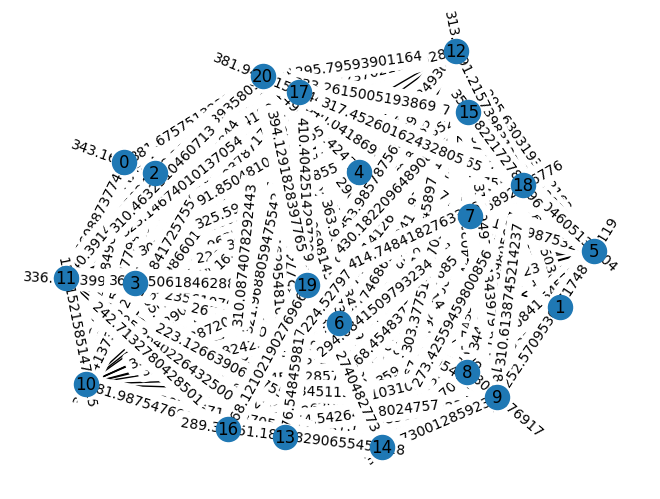

In [ ]:
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True)
edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.show()

### Сохраняем результат (все важные отрезки видео в одном видео)

In [ ]:
sorted_page_rank = sorted(page_rank.items(), key=lambda x: x[1], reverse=True)

top_segments = sorted_page_rank[:COUNT_IMPORTNANT_SEGMENTS]

In [ ]:
final_video = mp.concatenate_videoclips([mp.VideoFileClip(VIDEO_FILE).subclip(start*SEGMENT_LEN, start*SEGMENT_LEN + SEGMENT_LEN) for start, _ in top_segments])

# Сохраните итоговое видео
final_video.write_videofile("top_segments.mp4")

t:  29%|██▉       | 1838/6308 [1:15:44<10:14,  7.28it/s, now=None]

Moviepy - Building video top_segments.mp4.
MoviePy - Writing audio in top_segmentsTEMP_MPY_wvf_snd.mp3



t:  29%|██▉       | 1838/6308 [1:15:49<10:14,  7.28it/s, now=None]

MoviePy - Done.
Moviepy - Writing video top_segments.mp4




t:  29%|██▉       | 1838/6308 [1:20:25<10:14,  7.28it/s, now=None]

Moviepy - Done !
Moviepy - video ready top_segments.mp4
